# Problema del Comprador de comercio.
### Autor: Saúl Sosa Díaz


---
## El problema básico.
Consideremos un grafo $G = (V, A)$ que simboliza un mapa, el cual incluye nuestra casa y varios supermercados. En este grafo, el nodo 1 representa nuestra casa. Además, contamos con una red de supermercados interconectados $M = \{2 \dots n\}$ siendo n el número total de vértices en el grafo, cada uno con sus respectivos costos de desplazamiento $C = [C_a : a \in A]$. Junto a esto, disponemos de una lista de productos que deseamos adquirir $L = \{1 \dots m\}$ y la cantidad a comprar de cada uno de los elementos de la lista $D = [d_l : l \in L]$. 
En cada supermercado, existe una lista específica de productos disponibles $L_i \quad \forall i \in M$, Cabe destacar que $L_i \subseteq L$. Junto con sus precios. $P_{il} \quad \forall i \in M \land \forall l \in L_i$. Por último, también disponemos de la capacidad de ese artículo en el supermercado. $Q_{il} \quad \forall i \in M \land \forall l \in L_i$

Supondremos que $δ⁺(S) = \{(i,j) \in A : i \in S \land j \notin S\}$ y que $δ⁻(S) = δ⁺(V\setminus S)$.
Es decir, que estas notaciones se refieren a cómo se conectan nodos en un grafo entre sí. **$δ⁺(S)$** indica todas las rutas que comienzan en un grupo específico de nodos y terminan fuera de ese grupo. Por otro lado, **$δ⁻(S)$** representa todas las rutas que llegan a ese grupo de nodos desde aquellos que no están en el grupo.
Además, supondremos una función $X(F) = \sum_{i \in F} \sum_{j \in F, j \neq i} x_{ij}$.  

 
$\text{Donde }x_{ij} = \begin{dcases}
   1 &\text{Si el arco } a \in Tour \\
   0 &\text{Otro caso}.
\end{dcases} \text{ }\forall a \in A$

Es decir, la función $X(F)$ toma un conjunto específico de nodos $F$ y suma todos los valores asociados con las conexiones entre las nodos en ese conjunto.
Adicionalmente, usaremos las siguientes variables:

$\text{Donde }y_{i} = \begin{dcases}
   1 &\text{Si el mercado } i \in Tour \\
   0 &\text{Otro caso}.
\end{dcases} \text{ }\forall i \in M $

$\text{Donde }z_{il} = \text{ Cantidad de producto } l \text{ que se compra en el mercado } i \forall i \in M \land \forall l \in L$

Formalmente, se busca:
$$
    \begin{array}{ccc}
        &\min \sum_{a \in A} c_{a} x_{a} + \sum_{i \in M}\sum_{l \in L_i} p_{il} z_{il}
    \end{array}
$$

sujeto a:
$$
    \begin{array}{ccc} &
    \\ X(δ⁺(i)) = y_i \quad \forall i \in V \quad \text{De cada nodo elegido sale exactamente una arista.}\\
    X(δ⁻(i)) = y_i \quad \forall i \in V \quad \text{A cada nodo elegido le llega exactamente una arista.} & \\
    X(δ⁺(S)) \geq y_i \quad \forall S \subset V \setminus \{1\}\quad \text{Evitar los subtours.} & \\
    y_{1} = 1 \quad \text{Marcar el inicio.}\\
    \sum_{i \in M} Z_{il} = d_l \quad \forall l \in L \text{Asegurar la compra de la demanda.}\\
    Q_{il}y_i \geq Z_{il} \quad \forall i \in M \land l \in L \text{Asegurar que solo compro en un supermercado si compro en él.}\\
    \\
    X_{ij} \in \{0,1\} \quad\forall i \in V \land \forall j \in V \\
    y_{i} \in \{0,1\} \quad\forall i \in M \\
    Z_{il} \geq 0 \quad\forall i \in M \land \forall l \in L \\
    \end{array}
$$






## Resolución del problema.
Importamos los paquetes necesarios.

In [1]:
import Pkg
Pkg.add("JuMP")
Pkg.add("GLPK")
Pkg.add("Graphs")
Pkg.add("LightGraphs")
Pkg.add("LightGraphsFlows")
Pkg.add("GraphRecipes")
Pkg.add("GraphPlot")
Pkg.add("Plots")
Pkg.add("Compose")
Pkg.add("Cairo")
Pkg.add("Colors")

using JuMP, GLPK, LightGraphs, LightGraphsFlows, Graphs, GraphPlot, Random, Compose, Cairo, Colors, Printf, Random, Test, LinearAlgebra



    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Ch

### Introducimos los datos.

In [2]:
# Set the seed for reproducibility
Random.seed!(1234)
function readRandomInstance(N)
    coord = rand( 0:1000 , N, 2)
    cost  = zeros( Int32, N, N)
    for i=1:N, j=1:N
        cost[i,j]=round(sqrt((coord[i,1]-coord[j,1])^2+(coord[i,2]-coord[j,2])^2),digits=0)
    end
    return N,coord,cost
end

function IsInteger(N,sol)
    for i=1:N,j=1:N
        if EPS < sol[i,j] < 1-EPS
            return false
        end
    end
    return true
end

N, coord, C = readRandomInstance(10)
m = 10 # number of elements to buy
M = 2:N # set of markets
L = 1:m # set of elements to buy
d = rand(3:6, m) # demand of each element
p = rand(5:60, N, m) # price of each element in each market
q = rand(2:6, N, m) # quantity of each element in each market


10×10 Matrix{Int64}:
 4  4  5  5  3  3  6  4  4  3
 6  4  2  2  2  6  4  5  4  2
 5  3  3  5  5  6  5  2  5  3
 5  6  4  4  2  4  4  4  3  5
 2  6  5  4  2  4  6  3  3  6
 6  6  6  5  5  5  5  2  5  4
 4  2  6  4  4  2  4  5  6  4
 3  5  3  6  6  5  4  2  5  3
 2  6  4  3  6  5  2  4  5  5
 5  4  6  3  2  6  6  5  2  4

Mostramos el mapa visualmente. Y el horario de apertura de los planetas

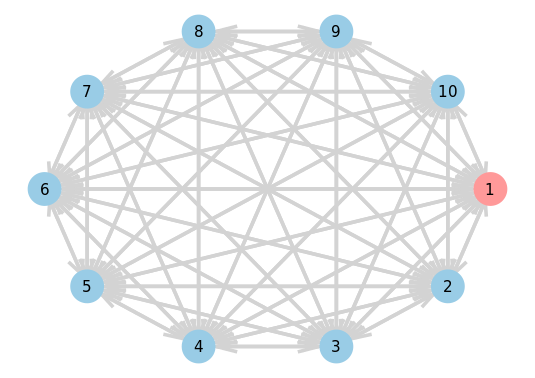

In [3]:
function PlotGraph(N, Costs)
    EPS = 0.00001
    G = Graphs.SimpleDiGraph(N)
    # Add the edges to the graph
    for i=1:N, j=1:N
        if Costs[i,j] > EPS
            Graphs.add_edge!(G,i,j)
        end
    end
    # Change the color of the first node to a pastel red, and the rest to a pastel blue.
    pastel_red = RGB(1.0, 0.6, 0.6)
    pastel_blue = RGB(0.6, 0.8, 0.9)
    node_colors = [pastel_red; fill(pastel_blue, N-1)]
    
    # Plot the graph
    p = gplot(G, nodelabel = 1:N, layout = circular_layout, nodefillc = node_colors)
    display(p)
    return
end

function AdjTour(N,sol)
    EPS = 0.00001
    pred = zeros(Int32,N)
    next = zeros(Int32,N)
    for i=1:N, j=1:N
        if sol[i,j] > EPS
            pred[j] = i
            next[i] = j
        end
    end
    return pred,next
end

function PrintTour(N,sol, buy)
    pred,next = AdjTour(N,sol)
    print("Tour: ")
    u = 1
    v = next[u]
    while v!=1
        print("$(u) => ")
        u = v
        v = next[u]
    end
    println("$(u)")
    for i in M
        bought = false
        string = "Comprado en el mercado $(i): \n"

        println()
        for j in M
            if buy[i,j] > 0
                bought = true
                cuantity = round(buy[i,j],digits=0)
                string = string * "   El artículo $(j) a un precio de $(p[i,j]) euros y una cantidad unitaria de $(cuantity) \n"
            end
        end
        if bought
            print(string)
            println("Importe total de la compra en el mercado $(i): $(round(sum(buy[i,j]*p[i,j] for j in M),digits=0)) euros")
        end
    end

end


PlotGraph(N, C)

### Construir el modelo.

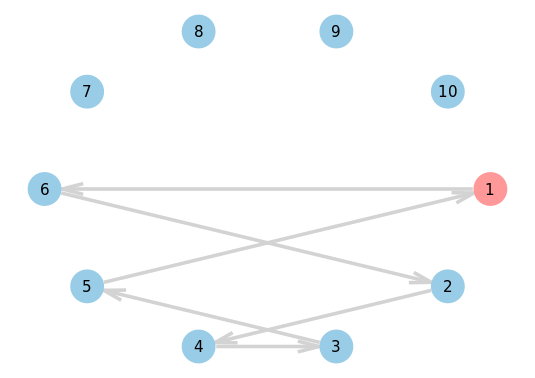

Optval: 2907.0 euros.
Tour: 1 => 6 => 2 => 4 => 3 => 5

Comprado en el mercado 2: 
   El artículo 5 a un precio de 33 euros y una cantidad unitaria de 1.0 
Importe total de la compra en el mercado 2: 33.0 euros

Comprado en el mercado 3: 
   El artículo 4 a un precio de 14 euros y una cantidad unitaria de 4.0 
   El artículo 8 a un precio de 7 euros y una cantidad unitaria de 2.0 
Importe total de la compra en el mercado 3: 70.0 euros

Comprado en el mercado 4: 
   El artículo 2 a un precio de 20 euros y una cantidad unitaria de 4.0 
   El artículo 5 a un precio de 11 euros y una cantidad unitaria de 2.0 
   El artículo 9 a un precio de 11 euros y una cantidad unitaria de 2.0 
Importe total de la compra en el mercado 4: 124.0 euros

Comprado en el mercado 5: 
   El artículo 5 a un precio de 25 euros y una cantidad unitaria de 2.0 
   El artículo 7 a un precio de 11 euros y una cantidad unitaria de 3.0 
   El artículo 8 a un precio de 16 euros y una cantidad unitaria de 3.0 
   El artíc

In [4]:
function CuttingPlane(model,x)
    while true
        optimize!(model)
        xval = JuMP.value.(x)
        G = Graphs.SimpleDiGraph( Graphs.Edge.([ (i,j) for i=1:N,j=1:N if xval[i,j]>0.5 ]) )
        Components = Graphs.connected_components(G)
        if length(Components)==1
            break
        end
        @constraint(model, [S in Components], sum(x[S,S]) <= length(S)-1 )
    end
end
    
function SolveComerciante()
    EPS = 0.00001
    model = Model(GLPK.Optimizer)
    set_silent(model)

    # Variables
    @variable(model, x[1:N,1:N], Bin)
    @variable(model, y[i in M], Bin)
    @variable(model, z[i in M, l in L] >= 0)

    for i in 1:N
        set_upper_bound(x[i,i], 0)
    end

    @objective(model, Min, sum(C[i,j] * x[i,j] for i in 1:N, j in 1:N) + sum(p[i, l] * z[i, l] for i in M, l in L))

    # Normal TSP constraints
    @constraint(model, sum(x[1,:]) == 1)
    @constraint(model, sum(x[:,1]) == 1)
    @constraint(model, [i=2:N], sum(x[i,:]) == y[i])
    @constraint(model, [i=2:N], sum(x[:,i]) == y[i])
    @constraint(model, y[2] == 1)
    
    for l in L
        @constraint(model, sum(z[i, l] for i in M) == d[l])
    end

    for i in M, l in L
        @constraint(model, q[i, l] * y[i] >= z[i, l])
    end
 
    # Dinamic constraints
    CuttingPlane(model,x)
    
    # Show solutions
    PlotGraph(N,value.(x))
    println("Optval: $( ceil(objective_value(model)-EPS) ) euros.")
    PrintTour(N, value.(x), value.(z))
end
SolveComerciante()